<a href="https://colab.research.google.com/github/mariuszknowak-experiments/binary-option-market-public/blob/main/Binary_option_market_equilibrium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm


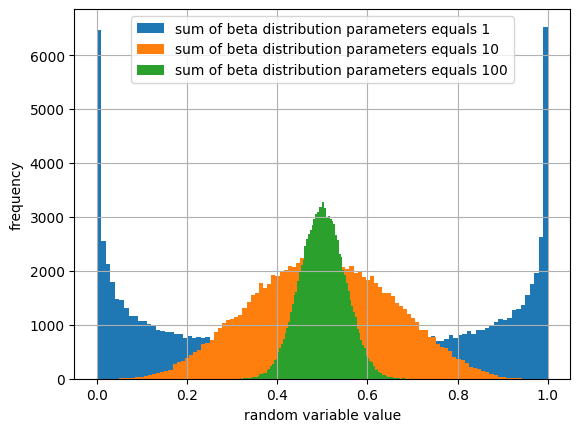

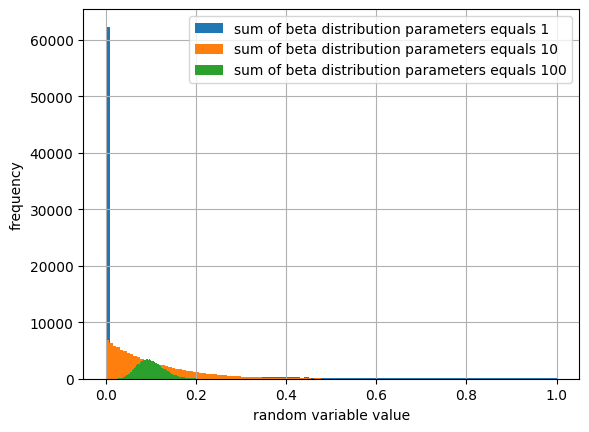

In [268]:
plt.hist(np.random.beta(0.5,0.5,int(1e5)),bins=100, label='sum of beta distribution parameters equals 1');
plt.hist(np.random.beta(5,5,int(1e5)),bins=100, label='sum of beta distribution parameters equals 10');
plt.hist(np.random.beta(50,50,int(1e5)),bins=100, label='sum of beta distribution parameters equals 100');
plt.xlabel('random variable value')
plt.ylabel('frequency')
plt.grid()
plt.legend()
plt.show()


plt.figure()
plt.hist(np.random.beta(0.1,0.9,int(1e5)),bins=100, label='sum of beta distribution parameters equals 1');
plt.hist(np.random.beta(1,9,int(1e5)),bins=100, label='sum of beta distribution parameters equals 10');
plt.hist(np.random.beta(10,90,int(1e5)),bins=100, label='sum of beta distribution parameters equals 100');
plt.xlabel('random variable value')
plt.ylabel('frequency')
plt.grid()
plt.legend()
plt.show()

In [220]:
def kelly_criterion(probability, binary_option_price):
  odds=(1-binary_option_price)/(binary_option_price)
  return (probability- (1-probability)/odds)

def naive_bet_size(market_participants_beliefs,binary_option_price):
  return 2*(market_participants_beliefs>0.5)-1


In [222]:
def kelly_net_bets_in_market(market_participants_beliefs,binary_option_price):
  return np.mean(kelly_criterion(market_participants_beliefs,binary_option_price))

def non_kelly_net_bets_in_market(market_participants_beliefs,binary_option_price):
  return np.mean(naive_bet_size(market_participants_beliefs,binary_option_price))

In [223]:


def equilibrium_price(market_participants_beliefs=None, fraction_dict={'kelly':1.,'non_kelly':0.,'net_buyer':0.}):
  total_fractions=sum(fraction_dict.values())
  for key in fraction_dict.keys():
    fraction_dict[key]/=total_fractions

  def net_buyers_in_market(price):
    return fraction_dict['kelly']*kelly_net_bets_in_market(market_participants_beliefs,price)+fraction_dict['non_kelly']*non_kelly_net_bets_in_market(market_participants_beliefs,price)+fraction_dict['net_buyer']

  return scipy.optimize.minimize(lambda price: np.square(net_buyers_in_market(price)),0.5,tol=1e-8,bounds=scipy.optimize.Bounds(1e-10,1-1e-10)).x[0]

0.05383875524460187 0.10114666796039239 0.0012169515184163348


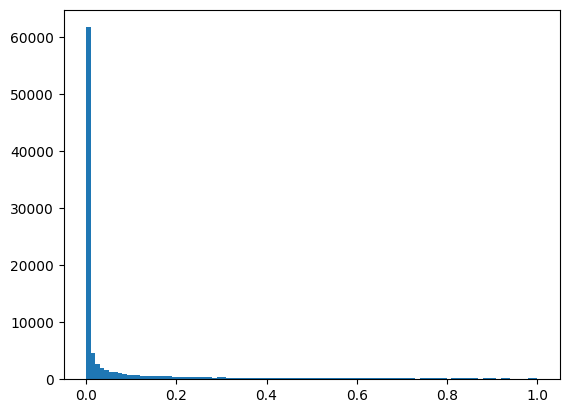

In [224]:
market_participants_beliefs=np.random.beta(0.1,0.9,int(1e5))
# non_kelly_market_participants_beliefs=kelly_market_participants_beliefs#np.random.beta(1,5,int(1e5))

# market_participants_beliefs=kelly_market_participants_beliefs
# if non_kelly_market_participants_beliefs is not None:
#   market_participants_beliefs=np.concatenate((market_participants_beliefs,non_kelly_market_participants_beliefs))

#market_participants_beliefs=np.random.normal(loc=0.1,scale=0.001,size=int(1e5))
#market_participants_beliefs=np.concatenate((np.zeros(int(1e5)),np.ones(int(9e5))))
# kelly_net_bets_in_market(market_participants_beliefs,0.9)

fraction_dict={'kelly':1.,'non_kelly':0.,'net_buyer':-0.05}
print(equilibrium_price(market_participants_beliefs,fraction_dict),np.mean(market_participants_beliefs),np.median(market_participants_beliefs))

plt.hist(market_participants_beliefs,bins=100);

In [225]:
market_participants_beliefs=np.random.beta(0.1,0.9,int(1e6))
fraction_dict={'kelly':1.,'non_kelly':0.,'net_buyer':0}
print(equilibrium_price(market_participants_beliefs,fraction_dict),np.mean(market_participants_beliefs),np.median(market_participants_beliefs))


0.10023633934292717 0.10023652482752153 0.0011562296017669318


In [226]:
market_participants_beliefs=np.random.beta(20,80,int(1e5))
non_kelly_frac_array=np.linspace(0,1,101)

result_list=list()
for el in non_kelly_frac_array:

  fraction_dict={'kelly':1-el,'non_kelly':el,'net_buyer':0}
  result_dict=fraction_dict
  result_dict['equilibrium_price']=equilibrium_price(market_participants_beliefs,fraction_dict)
  result_dict['mean']=np.mean(market_participants_beliefs)
  result_dict['median']=np.median(market_participants_beliefs)
  result_list.append(result_dict)


In [227]:
pd.DataFrame(result_list)

,kelly,non_kelly,net_buyer,equilibrium_price,mean,median
0,1.00,0.00,0.0,1.999904e-01,0.19999,0.197997
1,0.99,0.01,0.0,1.918270e-01,0.19999,0.197997
2,0.98,0.02,0.0,1.833234e-01,0.19999,0.197997
3,0.97,0.03,0.0,1.744580e-01,0.19999,0.197997
4,0.96,0.04,0.0,1.652076e-01,0.19999,0.197997
...,...,...,...,...,...,...
96,0.04,0.96,0.0,1.000000e-10,0.19999,0.197997
97,0.03,0.97,0.0,1.000000e-10,0.19999,0.197997
98,0.02,0.98,0.0,1.000000e-10,0.19999,0.197997
99,0.01,0.99,0.0,1.000000e-10,0.19999,0.197997


<Axes: xlabel='non_kelly', ylabel='equilibrium_price'>

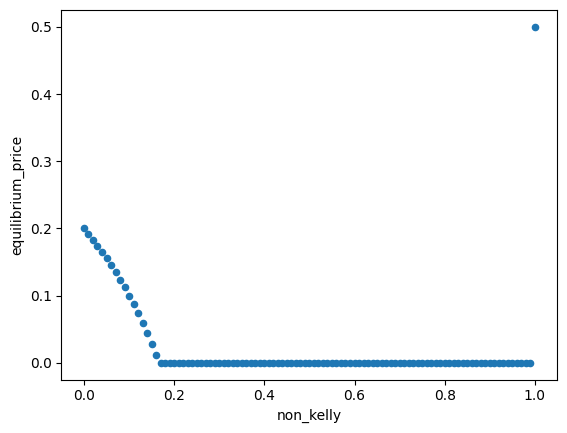

In [228]:
pd.DataFrame(result_list).plot.scatter(x='non_kelly',y='equilibrium_price')

In [229]:
np.mean(np.random.normal(loc=100,scale=15,size=int(1e6))>145)

0.001406

In [230]:
non_kelly_frac_array=np.linspace(0,1,101)
ab_sum_list=[1,10,100]
super_result_dict=dict()
for ab_sum in tqdm(ab_sum_list):
  a_frac=np.linspace(0.01,0.49,10)
  a_arr=ab_sum*a_frac
  b_arr=ab_sum*(1-a_frac)
  super_result_dict[ab_sum]=dict()
  for a,b in tqdm(zip(a_arr,b_arr)):
    market_participants_beliefs=np.random.beta(a,b,int(1e5))
    result_list=list()
    for el in non_kelly_frac_array:

      fraction_dict={'kelly':1-el,'non_kelly':el,'net_buyer':0}
      result_dict=fraction_dict
      result_dict['equilibrium_price']=equilibrium_price(market_participants_beliefs,fraction_dict)
      result_dict['mean']=np.mean(market_participants_beliefs)
      result_dict['median']=np.median(market_participants_beliefs)
      result_list.append(result_dict)
    super_result_dict[ab_sum][(a,b)]=result_list










  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

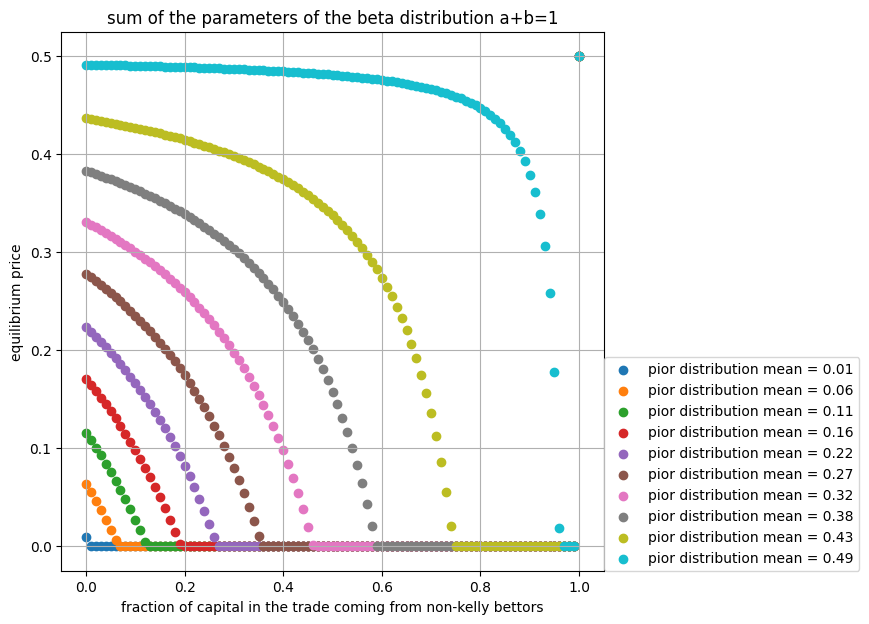

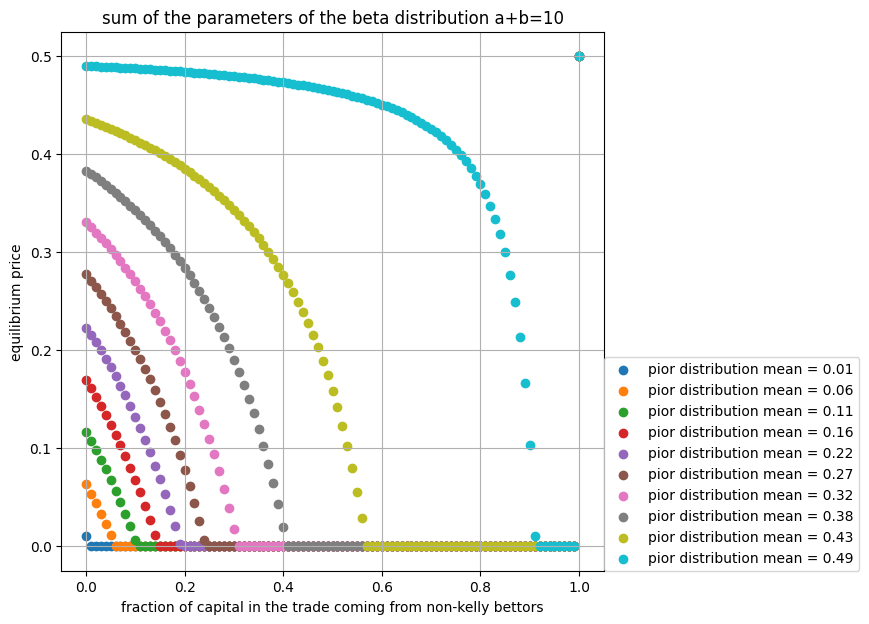

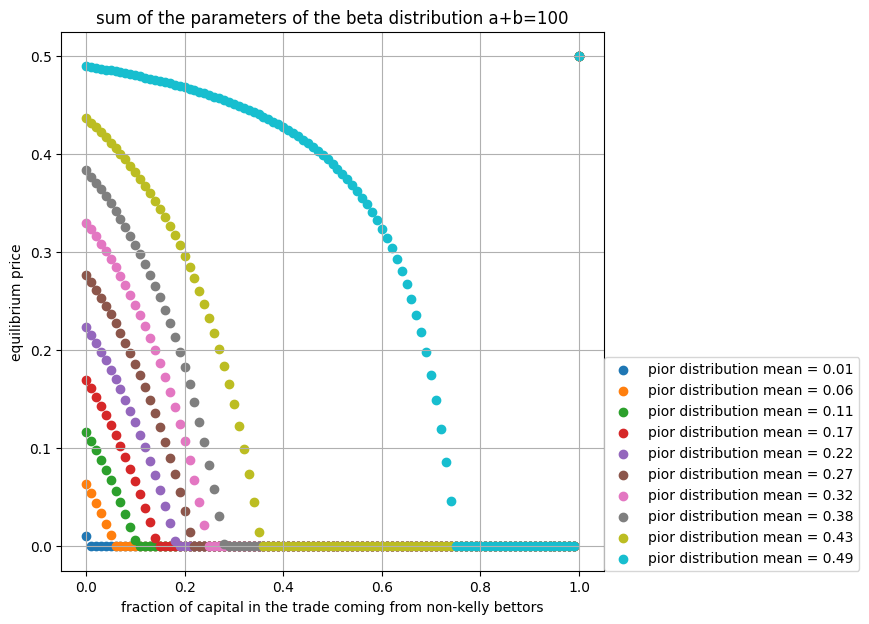

In [231]:
for key in  super_result_dict.keys():
  plt.figure(figsize=(7,7))
  plt.title("sum of the parameters of the beta distribution a+b="+str(key))
  for key2 in super_result_dict[key].keys():
    super_result_dict[key][key2]=pd.DataFrame(super_result_dict[key][key2])
    plt.scatter(super_result_dict[key][key2]['non_kelly'],super_result_dict[key][key2]['equilibrium_price'],label='pior distribution mean = '+str(key2[0]/(key2[0]+key2[1]))[:4])
  plt.legend(loc=(1,0))
  plt.xlabel('fraction of capital in the trade coming from non-kelly bettors')
  plt.ylabel('equilibrium price')
  plt.grid()
  plt.show()
  print('\n\n\n\n')


In [232]:
# market_failure_dict=dict()
# for key in  super_result_dict.keys():
#   for key2 in super_result_dict[key].keys():
#     super_result_dict[key][key2]=pd.DataFrame(super_result_dict[key][key2])
#     failure_threshold=super_result_dict[key][key2]['non_kelly'][np.argmax(super_result_dict[key][key2]['equilibrium_price']<=2e-10)]

#     market_failure_dict[key2[0]/(key2[0]+key2[1])]=dict()

#     market_failure_list.append(
#         {'sum of beta distribution parameters': key,
#          'pior distribution mean':key2[0]/(key2[0]+key2[1]),
#          'failure threshold':failure_threshold
#          }
#     )

In [233]:
market_failure_dict=dict()
for key in  super_result_dict.keys():
  for key2 in super_result_dict[key].keys():
    super_result_dict[key][key2]=pd.DataFrame(super_result_dict[key][key2])
    failure_threshold=super_result_dict[key][key2]['non_kelly'][np.argmax(super_result_dict[key][key2]['equilibrium_price']<=2e-10)]

    prior_mean=np.round(key2[0]/(key2[0]+key2[1]),3)
    if prior_mean not in market_failure_dict.keys():
      market_failure_dict[prior_mean]=dict()
    market_failure_dict[prior_mean]['failure threshold when sum of beta distribution parameters equals '+str(key)]=failure_threshold




    # market_failure_list.append(
    #     {'sum of beta distribution parameters': key,
    #      'pior distribution mean':key2[0]/(key2[0]+key2[1]),
    #      'failure threshold':failure_threshold
    #      }
    # )


  #   print("for the prior probability distribution beta"+str(key2)+':\ncomplete market failure happens when '+str(super_result_dict[key][key2]['non_kelly'][np.argmax(super_result_dict[key][key2]['equilibrium_price']<=2e-10)])[:4]+' of trade capital comes from non-kelly bettors\n')
  #   #plt.scatter(super_result_dict[key][key2]['non_kelly'],super_result_dict[key][key2]['equilibrium_price'],label='pior distribution mean = '+str(key2[0]/(key2[0]+key2[1]))[:4])
  # print('\n\n')


In [234]:
market_failure_df=pd.DataFrame(market_failure_dict)
market_failure_df.index.name='pior distribution mean'
market_failure_df.sort_index()


,0.010,0.063,0.117,0.170,0.223,0.277,0.330,0.383,0.437,0.490
pior distribution mean,,,,,,,,,,
failure threshold when sum of beta distribution parameters equals 1,0.01,0.07,0.13,0.20,0.27,0.36,0.47,0.59,0.75,0.97
failure threshold when sum of beta distribution parameters equals 10,0.02,0.06,0.11,0.15,0.20,0.25,0.31,0.41,0.57,0.92
failure threshold when sum of beta distribution parameters equals 100,0.01,0.06,0.11,0.15,0.19,0.22,0.25,0.29,0.36,0.75


In [243]:
market_failure_df.T['failure threshold when sum of beta distribution parameters equals 1']

,failure threshold when sum of beta distribution parameters equals 1
0.010,0.01
0.063,0.07
0.117,0.13
0.170,0.20
0.223,0.27
0.277,0.36
0.330,0.47
0.383,0.59
0.437,0.75
0.490,0.97


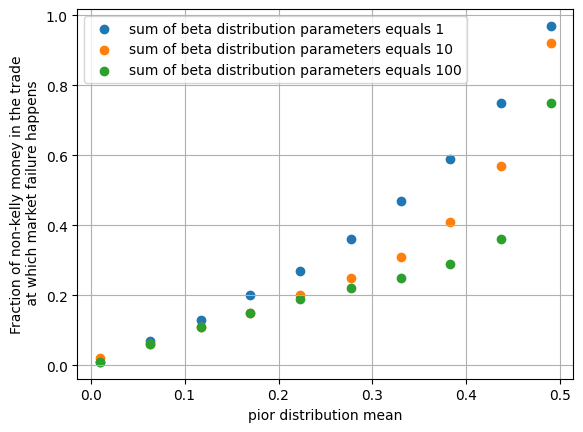

In [252]:
plt.scatter(x=market_failure_df.T.index,y=market_failure_df.T['failure threshold when sum of beta distribution parameters equals 1'],label='sum of beta distribution parameters equals 1')
plt.scatter(x=market_failure_df.T.index,y=market_failure_df.T['failure threshold when sum of beta distribution parameters equals 10'],label='sum of beta distribution parameters equals 10')
plt.scatter(x=market_failure_df.T.index,y=market_failure_df.T['failure threshold when sum of beta distribution parameters equals 100'],label='sum of beta distribution parameters equals 100')

plt.xlabel('pior distribution mean')
plt.ylabel('Fraction of non-kelly money in the trade\n at which market failure happens')
plt.grid()
plt.legend()
plt.show()

In [238]:
market_failure_df['pior distribution mean']

KeyError: 'pior distribution mean'